In [1]:
import math
import numpy as np
from torch import cos, sin
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *

from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import sample_farthest_points
from descartes import PolygonPatch
from pytorch3d.io import IO, load_obj, save_obj,load_objs_as_meshes
from pytorch3d.structures import join_meshes_as_scene, Meshes, Pointclouds

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from alpha_shapes import Alpha_Shaper, plot_alpha_shape
from torch import Tensor, tensor

import shapely
import os

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
torch.autograd.set_detect_anomaly(True)

def least_squares(u0, tgt_vtxs):
    """
    u0 are vertices
    """
    if not torch.is_tensor(u0):
        u0 = torch.tensor(u0)
    if not torch.is_tensor(tgt_vtxs):
        tgt_vtxs = torch.tensor(tgt_vtxs)
    res = torch.square(u0 - tgt_vtxs.flatten()).sum()
    return res.double()

def least_squares_grad(u0, tgt_vtxs):
    if torch.is_tensor(u0):
        u0 = u0.detach().clone()
    else:
        u0 = torch.tensor(u0)
    if torch.is_tensor(tgt_vtxs):
        tgt_vtxs = tgt_vtxs.detach().clone()
    else:
        tgt_vtxs = torch.tensor(tgt_vtxs)
        
    # Ensure that u0 requires gradients
    gradient = 2 * (u0 - tgt_vtxs.flatten())
    return gradient.double()


def calculate_volume(vertices, faces):
    face_vertices = vertices[faces]  # (F, 3, 3)
    v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
    
    # Compute determinant of the 3x3 matrix [v0, v1, v2]
    face_volumes = torch.det(torch.stack([v0, v1, v2], dim=-1)) / 6.0  # Shape: (F,)
    volume = face_volumes.sum()
    return volume.abs()


def volume_constraint(x, faces, tgt_vol):
    """
    Calculate the volume of a mesh using PyTorch tensors.
    Args:
        vertices_torch: Nx3 tensor of vertex coordinates
        faces: Mx3 array of face indices
    Returns:
        volume: Total volume of the mesh as a PyTorch scalar
    """
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces)
    if not torch.is_tensor(tgt_vol):
        tgt_vol = torch.tensor(tgt_vol)

    vertices = x.view(-1,3)
    faces = faces.view(-1,3).int()
    volume = calculate_volume(vertices, faces)
    res = volume.abs() - tgt_vol
    return res.double()

def volume_constraint_grad(x, faces):
    if torch.is_tensor(x):
        x = x.detach().clone()
    else:
        x = torch.tensor(x)
    if torch.is_tensor(faces):
        faces = faces.detach().clone()
    else:
        faces = torch.tensor(faces)
    faces = faces.to(dtype=torch.int64)

    vertices_torch = x.view(-1, 3)
    p0 = vertices_torch[faces[:, 0]]  # (F, 3)
    p1 = vertices_torch[faces[:, 1]]  # (F, 3)
    p2 = vertices_torch[faces[:, 2]]  # (F, 3)

    grad_p0 = torch.cross(p1, p2, dim=1) / 6.0
    grad_p1 = torch.cross(p2, p0, dim=1) / 6.0
    grad_p2 = torch.cross(p0, p1, dim=1) / 6.0

    grad_verts = torch.zeros_like(vertices_torch)
    grad_verts.scatter_add_(0, faces[:, 0].unsqueeze(1).expand(-1, 3), grad_p0)
    grad_verts.scatter_add_(0, faces[:, 1].unsqueeze(1).expand(-1, 3), grad_p1)
    grad_verts.scatter_add_(0, faces[:, 2].unsqueeze(1).expand(-1, 3), grad_p2)

    analytical_grad = grad_verts.flatten()
    return analytical_grad 

def padded_to_packed(xs, lengths):
    packed = []
    batch_size = xs.size(0)
    for b in range(batch_size):
        n = lengths[b]
        packed.append(xs[b][:n])
    packed = torch.cat(packed, dim=0)
    return packed

y* = argmin ||X - tgt||^2

target depends on input X

We have mesh points in 3D <-- X
2D edge maps <-- upper level targets

lower level: find Y closest to X that satisfy volume constraint, so Y is being optimised in the lower point

argmin ||X - Y||^2 s.t. vol(Y) = constant

In [96]:
class ConstrainedProjectionNode(EqConstDeclarativeNode):
    """
    Performs a projection of the input points X onto the nearest points Y such that the volume of Y is constant.
    """
    def __init__(self, src: Meshes, tgt: Meshes):
        super().__init__(eps=1.0e-6) # relax tolerance on optimality test 
        self.src = src # source meshes (B,)
        # self.tgt = tgt # target meshes (B,)
        self.b = len(src)

    def objective(self, xs: torch.Tensor, y: torch.Tensor, scatter_add=False):
        """
        Calculates sum of squared differences between source and target meshes.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices        
        """
        src_verts = padded_to_packed(xs, self.src.num_verts_per_mesh()).view(-1,3)
        tgt_verts = padded_to_packed(y, self.src.num_verts_per_mesh()).view(-1,3)

        sqr_diffs = torch.square(src_verts - tgt_verts).sum(dim=-1) # (sum(V_i))
        n_batches = len(self.src)
        sse = torch.zeros(n_batches, dtype=sqr_diffs.dtype)
        if scatter_add:
            sse.scatter_add_(0, self.src.verts_packed_to_mesh_idx(), sqr_diffs)
        else:
            n_verts_per_mesh = self.src.num_verts_per_mesh()
            for i in range(n_batches):
                mesh_to_vert = self.src.mesh_to_verts_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_vert[i]
                end = start + n_verts_per_mesh[i]
                sse[i] = sqr_diffs[start:end].sum()  # Sum over all faces
        return sse

    def equality_constraints(self, xs, y, scatter_add=False):
        """
        Enforces volume constraint of projected points
        Assumes same number of vertices in each projected mesh currently

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        y_packed = padded_to_packed(y, self.src.num_verts_per_mesh())
        verts_packed = y_packed.view(-1,3) # (sum(V_i), 3)

        faces_packed = self.src.faces_packed()  # (sum(F_i), 3)
        face_vertices = verts_packed[faces_packed]  # (sum(F_i), 3, 3)
        
        # Calculate tetrahedron volumes for each face
        v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
        cross_product = torch.cross(v0, v1, dim=-1)  # (F, 3)
        face_volumes = torch.sum(cross_product * v2, dim=-1) / 6.0  # (F,)
        volumes = torch.zeros(n_batches, device=verts_packed.device, dtype=face_volumes.dtype)
        if scatter_add:
            volumes.scatter_add_(0, self.src.faces_packed_to_mesh_idx(), face_volumes)
        else:
            n_faces_per_mesh = self.src.num_faces_per_mesh()
            for i in range(n_batches):
                mesh_to_face = self.src.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_face[i]
                end = start + n_faces_per_mesh[i]
                volumes[i] = face_volumes[start:end].sum()  # Sum over all faces

        volumes = volumes.abs()
        return volumes  # Shape: (B,)    
    
    def solve(self, xs: torch.Tensor):
        """Projects the vertices onto the target mesh vertices across batches.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of vertices in the batched meshes

        Returns:
            results (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        results = torch.zeros((n_batches, num_verts_per_mesh.max(), 3), dtype=torch.double)
        for batch in range(n_batches):
            n_verts = num_verts_per_mesh[batch]
            verts = xs[batch][:n_verts].flatten().detach().double().cpu().numpy()
            faces = self.src[batch].faces_packed().detach().int().cpu().numpy()
            
            # Y = xs[batch][:n_verts].flatten().detach().double().cpu() * 2
            # Y = Y.numpy()
            Y = xs[batch][:n_verts].flatten().detach().double().cpu().numpy()

            with torch.no_grad():
                src_vtx = self.src[batch].verts_packed().detach()
                src_faces = self.src[batch].faces_packed().detach()
                vol = calculate_volume(src_vtx, src_faces)

            eq_constraint = {
                'type': 'eq',
                'fun' : lambda u: volume_constraint(u, faces, vol).cpu().numpy(),
                'jac' : lambda u: volume_constraint_grad(u, faces).cpu().numpy(),
            }

            res = opt.minimize(
                lambda u: least_squares(u, verts).detach().cpu().numpy(),
                Y,
                method='SLSQP',
                jac=lambda u: least_squares_grad(u, verts).cpu().numpy(),
                constraints=[eq_constraint],
                options={'ftol': 1e-4, 'iprint': 2, 'maxiter': 100}
            )

            if not res.success:
                print("FAILED:", res.message)
            results[batch] = torch.tensor(res.x, dtype=torch.double, requires_grad=True).view(-1,3)
        results = torch.nn.utils.rnn.pad_sequence(results, batch_first=True)
        return results,None
    

class ConstrainedProjectionFunction(DeclarativeFunction):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


Pseudo code:
- load in the meshes
- inner problem needs access to the vertices, number of meshes, faces, and indexing
- outer problem needs access to projected vertices, number of meshes, and indexing. Also needs projection matrices, and edge maps of renders, so perform edge detection of renders beforehand.

just provide both with the meshes lol

Projection:
Get the indexing correct for the vertices, take the projection of these vertices

In [5]:
# outer problem

def create_padded_tensor(vertices, vert2mesh, max_V, B):
    padded = torch.zeros((B, max_V, 3),device=vertices.device)
    for i in range(B):
        mesh_vertices = vertices[vert2mesh == i]
        num_vertices = mesh_vertices.shape[0]
        padded[i, :num_vertices, :] = mesh_vertices
    return padded

def get_boundary(projected_pts, alpha=35.0):
    # Create a detached copy for Alpha_Shaper
    projected_pts_detached = projected_pts.detach().clone()
    
    # Use the detached copy with Alpha_Shaper
    shaper = Alpha_Shaper(projected_pts_detached)
    alpha_shape = shaper.get_shape(alpha)
    while isinstance(alpha_shape, shapely.MultiPolygon) or isinstance(alpha_shape, shapely.GeometryCollection):
        alpha -= 1
        alpha_shape = shaper.get_shape(alpha)
    boundary = torch.tensor(alpha_shape.exterior.coords.xy, dtype=torch.double)
    
    # Find indices of boundary points
    boundary_indices = torch.where(
        torch.any(torch.isclose(projected_pts_detached[:, None], boundary.T, atol=1e-6).all(dim=-1), dim=1)
    )[0]
    
    # Index back into the original tensor with gradients
    boundary_pts = projected_pts[boundary_indices]
    
    # print(boundary_pts.requires_grad)  # This should now be True
    return boundary_pts

import torch

def chamfer_distance_torch(x, y, x_lengths=None, y_lengths=None, batch_reduction="mean", point_reduction="mean"):
    """
    Compute Chamfer Distance between two sets of points using PyTorch.

    Args:
        x (torch.Tensor): (B, N, D) tensor of batch B, N points, and D dimensions.
        y (torch.Tensor): (B, M, D) tensor of batch B, M points, and D dimensions.
        x_lengths (torch.Tensor, optional): (B,) number of valid points in x per batch.
        y_lengths (torch.Tensor, optional): (B,) number of valid points in y per batch.
        batch_reduction (str, optional): "mean" or "sum" for reducing over batch.
        point_reduction (str, optional): "mean" or "sum" for reducing over points.

    Returns:
        torch.Tensor: Chamfer distance per batch.
    """
    B, N, D = x.shape
    _, M, _ = y.shape

    # Compute pairwise squared distances ||x - y||^2
    x_exp = x.unsqueeze(2)  # (B, N, 1, D)
    y_exp = y.unsqueeze(1)  # (B, 1, M, D)
    pairwise_dist = torch.norm(x_exp - y_exp, dim=-1, p=2) ** 2  # (B, N, M)

    # Find min distances for each point in X to Y, and vice versa
    x_to_y_min = pairwise_dist.min(dim=2)[0]  # (B, N)
    y_to_x_min = pairwise_dist.min(dim=1)[0]  # (B, M)

    # Mask out padding if lengths are given
    if x_lengths is not None:
        mask_x = torch.arange(N, device=x.device).unsqueeze(0) >= x_lengths.unsqueeze(1)
        x_to_y_min[mask_x] = 0.0  # Ignore invalid points
    if y_lengths is not None:
        mask_y = torch.arange(M, device=y.device).unsqueeze(0) >= y_lengths.unsqueeze(1)
        y_to_x_min[mask_y] = 0.0

    # Reduce over points
    if point_reduction == "mean":
        x_to_y_dist = x_to_y_min.sum(dim=1) / x_lengths.float()
        y_to_x_dist = y_to_x_min.sum(dim=1) / y_lengths.float()
    elif point_reduction == "sum":
        x_to_y_dist = x_to_y_min.sum(dim=1)
        y_to_x_dist = y_to_x_min.sum(dim=1)
    else:
        raise ValueError("Invalid point_reduction: Choose 'mean' or 'sum'.")

    chamfer_dist = x_to_y_dist + y_to_x_dist  # (B,)

    # Reduce over batch
    if batch_reduction == "mean":
        chamfer_dist = chamfer_dist.mean()
    elif batch_reduction == "sum":
        chamfer_dist = chamfer_dist.sum()
    
    return chamfer_dist

class PyTorchChamferLoss(nn.Module):
    def __init__(self, src: Meshes, tgt: Meshes, projmatrices, edgemap_info):
        super().__init__()
        self.src = src  # (B meshes)
        self.tgt = tgt  # (B meshes)
        self.projmatrices = projmatrices # (P, 3, 4)
        self.edgemaps = edgemap_info[0] # (P, max_Ni, 2)
        self.edgemaps_len = edgemap_info[1] # (P,)
    
    def project_vertices(self, vertices):
        """
        Projects a set of vertices into multiple views using different projection matrices.

        Args:
            vertices: Tensor of shape (N, 3), representing 3D vertex positions.

        Returns:
            Tensor of shape (P, N, 2), containing projected 2D points in each view.
        """
        V = vertices.shape[0]
        projection_matrices = self.projmatrices

        ones = torch.ones((V, 1), dtype=vertices.dtype, device=vertices.device)
        vertices_homogeneous = torch.cat([vertices, ones], dim=1).double()  # Shape: (V, 4)

        # Perform batched matrix multiplication (P, 3, 4) @ (V, 4, 1) -> (P, V, 3)
        projected = torch.einsum("pij,vj->pvi", projection_matrices, vertices_homogeneous)  # (P, V, 3)
        
        projected_cartesian = projected[:, :, :2] / projected[:, :, 2:3]  # (P, V, 2)

        return projected_cartesian

        
    def forward(self, y):
        B, P = len(self.src), self.projmatrices.size(0)
        vertices = y
        # project vertices
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        projected_vertices = [] # (B, P, V, 2)
        for b in range(B):
            end = num_verts_per_mesh[b]
            projverts = self.project_vertices(vertices[b][:end,:])  # Shape: (P, V, 2)
            projected_vertices.append(projverts)  # Store without padding

        # get boundaries
        boundaries = [] 
        boundary_lengths = torch.zeros(B, P)
        for b, batch in enumerate(projected_vertices):
            boundaries_b = []
            for p, projverts in enumerate(batch):
                boundary = get_boundary(projverts)
                boundaries_b.append(boundary)
                boundary_lengths[b,p] = len(boundary)
            # stacked_boundaries = torch.stack(boundaries_b)
            padded_boundaries = torch.nn.utils.rnn.pad_sequence(boundaries_b, batch_first=True, padding_value=0.0)
            boundaries.append(padded_boundaries)

        # perform chamfer
        chamfer_loss = torch.zeros(B)
        for b in range(B):
            boundaries_b = boundaries[b].float()
            edgemaps_b = self.edgemaps[b].float()
            res, _ = chamfer_distance(  x=boundaries_b,
                                        y=edgemaps_b,
                                        x_lengths=boundary_lengths[b].long(),
                                        y_lengths=self.edgemaps_len[b].long(),
                                        # batch_reduction="mean",
                                        point_reduction="mean")
            # res = chamfer_distance_torch(  x=boundaries_b,
            #                             y=edgemaps_b,
            #                             x_lengths=boundary_lengths[b].long(),
            #                             y_lengths=self.edgemaps_len[b].long(),
            #                             batch_reduction="mean",
            #                             point_reduction="mean")
            chamfer_loss[b] = res.sum()
        return chamfer_loss.double() * 10



In [74]:
def plot_projections(projverts, projmats, edgemaps, alpha=0.0):
    P, _, _ = projmats.shape
    edge_coords, edge_lens = edgemaps
    fig, axes = plt.subplots(1, P, figsize=(2 * P, 2))
    if P == 1:
        axes = [axes]  # Ensure iterable for a single subplot case
    for i in range(P):
        proj_2d_hom = (projmats[i] @ torch.cat([projverts, torch.ones(projverts.shape[0], 1)], dim=1).T).T
        proj_2d = proj_2d_hom[:, :2] / proj_2d_hom[:, 2:3]  # Normalize by depth

        # Get boundary points
        boundary_pts = get_boundary(proj_2d)
        valid_edges = edge_coords[i, :edge_lens[i]]

        ax = axes[i]
        ax.scatter(proj_2d[:, 0], proj_2d[:, 1], c='b', s=5, label="Projected Vertices")
        ax.scatter(valid_edges[:, 0], valid_edges[:, 1], c='r', s=1, label="Edge Coordinates")
        ax.scatter(boundary_pts[:, 0], boundary_pts[:, 1], c='g', s=1, label="Boundary Points")

        ax.set_title(f"Projection {i+1}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.axis("equal")
        # ax.legend()
        ax.invert_yaxis()  # Ensure alignment with image coordinates

    plt.tight_layout()
    plt.show()

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# plot_projections(sphere.verts_packed().double(), projmats, (tgt_edgemaps, tgt_edgemaps_len))
def outer_problem(src: Meshes, tgt: Meshes, projmats, edgemap_info, n_iters, lr, moment, verbose=True):
    node = ConstrainedProjectionNode(src, tgt)
    verts_init = src.verts_padded() # (B, max Vi, 3)
    verts_init.requires_grad = True
    projverts_init = node.solve(verts_init)
    # apply solve
    projverts_init = ConstrainedProjectionFunction.apply(node, verts_init) # (B, max Vi, 3)
    # print("projverts_init requires_grad:", projverts_init.requires_grad)

    chamfer_loss = PyTorchChamferLoss(src, tgt, projmats, edgemap_info)

    history = [projverts_init]
    verts = verts_init.clone().detach().requires_grad_(True)
    # print("verts requires_grad:", verts.requires_grad)

    optimiser = torch.optim.SGD([verts], lr=lr, momentum=moment)
    a,b = edgemap_info
    a,b = a[0], b[0]

    plot_projections(verts.detach().squeeze().double(), projmats, (a,b))

    min_loss = float("inf")
    best_verts = None
    # verts_prev = None
    improvement = False
    for i in range(n_iters):
        optimiser.zero_grad(set_to_none=True)
        projverts = ConstrainedProjectionFunction.apply(node, verts)
        history.append(projverts.detach().clone())
        loss = chamfer_loss(projverts)
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_verts = projverts.detach().clone()
            improvement=True
        loss.backward()
        optimiser.step()
        if verbose:
            # print(f"{i:4d} Loss: {loss.item()} Gradient: {verts.grad}")
            colour = bcolors.OKGREEN if improvement else bcolors.FAIL
            print(f"{i:4d} Loss: {colour}{loss.item()}{bcolors.ENDC} Volume: {calculate_volume(projverts[0], src[0].faces_packed()):3f} SSE: {(torch.norm(projverts - verts_init)**2).sum()} Chamfer: {chamfer_distance(projverts.float(),verts_init.float())[0].sum()}")
            if i % 10 == 9:
                plot_projections(projverts.detach().squeeze().double(), projmats, (a,b))
        improvement=False
        # optimiser.zero_grad(set_to_none=True)
        # history.append(verts.detach().clone())
        # loss = chamfer_loss(verts)
        # loss.backward()
        # optimiser.step()
        # if loss.item() < min_loss:
        #     print("Saving best new verts")
        #     min_loss = loss.item()
        #     best_verts = verts.detach().clone()

        # if verbose:
        #     # print(f"{i:4d} Loss: {loss.item()} Gradient: {verts.grad}")
        #     print(f"{i:4d} Loss: {loss.item()}")
        #     if i % 19 == 0:
        #         plot_projections(verts.detach().squeeze().double(), projmats, (a,b))
    return best_verts, history

In [65]:
from utils import load_renders, load_camera_matrices, get_projmats_and_edgemap_info
import cv2
from cv2.typing import MatLike

# Apply Canny edge detection
def canny_edge_map(img: MatLike):
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # apply edge detection
    # edge_map = cv2.Canny(img_greyscale, threshold1=20, threshold2=100)
    edge_map = cv2.Canny(img_greyscale, threshold1=15, threshold2=250)
    # return edge map
    return edge_map

def get_edgemaps(renders):
    edgemaps = {}
    edgemaps_len = {}
    for k,v in renders.items():
        views = {}
        views_len = {}
        for num, img in v.items():
            edges = canny_edge_map(img)
            edge_coords = np.argwhere(edges > 0)
            edge_coords = edge_coords[:, [1,0]]  
            views[num] = torch.tensor(edge_coords)
            views_len[num] = len(edge_coords)
        edgemaps[k] = views
        edgemaps_len[k] = views_len
    return edgemaps, edgemaps_len


paths = [os.path.join("../data/meshes/", f"{name}_2.obj") for name in ["sphere", "balloon", "parabola", "rstrawberry"]]
sphere, balloon, parabola, rstrawberry = load_objs_as_meshes(paths)
renders_path = "../data/renders"
renders = load_renders(renders_path)
edgemaps, edgemaps_len = get_edgemaps(renders)
matrices_path = "../data/cameras"
matrices = load_camera_matrices(matrices_path)

In [55]:
calculate_volume(sphere.verts_packed(), sphere.faces_packed())
calculate_volume(balloon.verts_packed(), balloon.faces_packed())

tensor(4.2485)

In [90]:
# view_idx = [2,3,4,7,8,9,11]
view_idx = [4,7,8,9,11]
tgt = "balloon"
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])

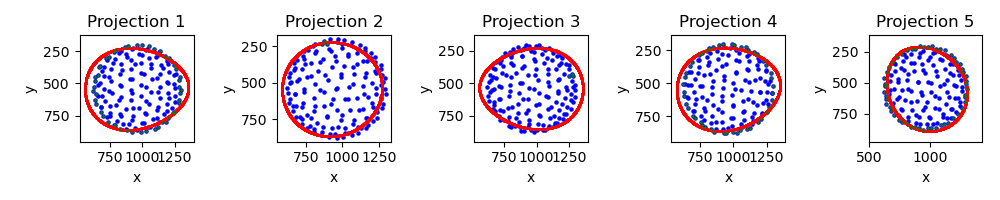

   0 Loss: 854915.859375 Volume: 4.249396 SSE: 0.0 Chamfer: 0.0
   1 Loss: 382869.296875 Volume: 4.249366 SSE: 0.07323992478569834 Chamfer: 0.0009041966404765844
   2 Loss: 1144508.359375 Volume: 4.249423 SSE: 0.10611307799646784 Chamfer: 0.001310038031078875
   3 Loss: 820438.125 Volume: 4.249314 SSE: 0.1860677477057005 Chamfer: 0.0022971327416598797
   4 Loss: 702949.375 Volume: 4.249396 SSE: 0.24719532117445933 Chamfer: 0.00305179413408041
   5 Loss: 369874.140625 Volume: 4.249396 SSE: 0.34300954721425303 Chamfer: 0.003964208997786045
   6 Loss: 17201.09375 Volume: 4.249396 SSE: 0.38053485144280985 Chamfer: 0.004428772255778313
   7 Loss: 16729.00634765625 Volume: 4.249396 SSE: 0.38384159960509284 Chamfer: 0.0044688875786960125
   8 Loss: 905663.671875 Volume: 4.249396 SSE: 0.3875299997049524 Chamfer: 0.004513723310083151
   9 Loss: 728815.46875 Volume: 4.249396 SSE: 0.459266639775149 Chamfer: 0.005408097989857197


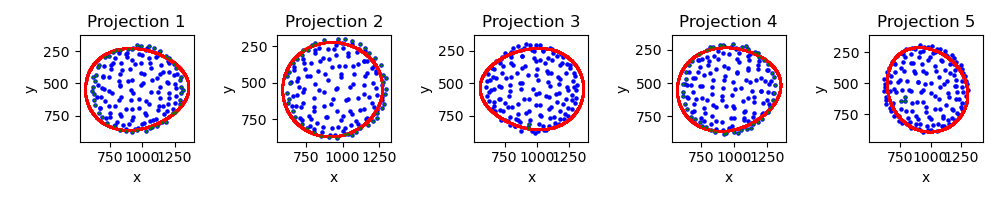

  10 Loss: 319964.00390625 Volume: 4.249396 SSE: 0.5173199058720223 Chamfer: 0.006067419890314341
  11 Loss: 347329.765625 Volume: 4.249396 SSE: 0.5069384592186259 Chamfer: 0.005995904095470905
  12 Loss: 416802.734375 Volume: 4.249396 SSE: 0.5131290755246054 Chamfer: 0.006070738658308983
  13 Loss: 14523.1640625 Volume: 4.249396 SSE: 0.5512223827612082 Chamfer: 0.006541155278682709
  14 Loss: 459802.109375 Volume: 4.249396 SSE: 0.5563562887078378 Chamfer: 0.006601605098694563
  15 Loss: 867907.421875 Volume: 4.249396 SSE: 0.597678269450368 Chamfer: 0.007122691720724106
  16 Loss: 800996.015625 Volume: 4.249396 SSE: 0.6883733769852003 Chamfer: 0.00824988353997469
  17 Loss: 845397.03125 Volume: 4.249396 SSE: 0.8313697585493643 Chamfer: 0.009742414578795433
  18 Loss: 809159.375 Volume: 4.249396 SSE: 0.861964679679202 Chamfer: 0.010132431983947754
  19 Loss: 778033.125 Volume: 4.249396 SSE: 0.9036029256011953 Chamfer: 0.010655602440237999


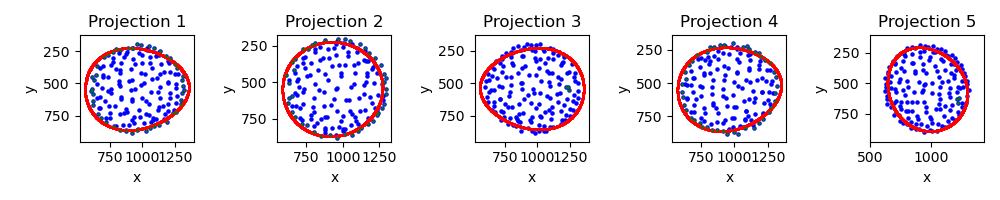

  20 Loss: 334718.0078125 Volume: 4.249396 SSE: 0.9890754382024476 Chamfer: 0.011663844808936119
  21 Loss: 350051.6015625 Volume: 4.249396 SSE: 0.9886384929345541 Chamfer: 0.011709773913025856
  22 Loss: 392963.984375 Volume: 4.249396 SSE: 1.0130883904674761 Chamfer: 0.012011021375656128
  23 Loss: 12872.852783203125 Volume: 4.249396 SSE: 1.0653760695519259 Chamfer: 0.012511160224676132
  24 Loss: 464380.3515625 Volume: 4.249396 SSE: 1.0702533790356044 Chamfer: 0.012567481026053429
  25 Loss: 367837.734375 Volume: 4.249396 SSE: 1.1124456113680588 Chamfer: 0.013100091367959976
  26 Loss: 12416.84814453125 Volume: 4.249396 SSE: 1.1372981705516538 Chamfer: 0.013407878577709198
  27 Loss: 12233.94775390625 Volume: 4.249396 SSE: 1.1423064583137654 Chamfer: 0.013466285541653633
  28 Loss: 11958.70361328125 Volume: 4.249396 SSE: 1.147420337518852 Chamfer: 0.013526113703846931
  29 Loss: 385922.109375 Volume: 4.249396 SSE: 1.1526234541883191 Chamfer: 0.013587083667516708


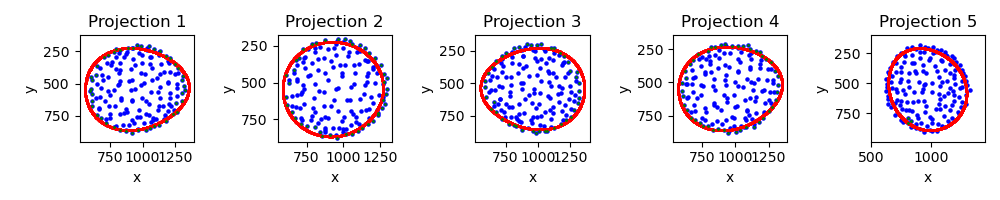

  30 Loss: 331147.265625 Volume: 4.249396 SSE: 1.1806412532136172 Chamfer: 0.013939806260168552
  31 Loss: 347511.71875 Volume: 4.249396 SSE: 1.1856117958404262 Chamfer: 0.014023680239915848
  32 Loss: 349039.21875 Volume: 4.249396 SSE: 1.23771319669304 Chamfer: 0.014659417793154716
  33 Loss: 418582.5 Volume: 4.249396 SSE: 1.2727949357095858 Chamfer: 0.015105962753295898
  34 Loss: 423267.578125 Volume: 4.249396 SSE: 1.288580381387872 Chamfer: 0.015310674905776978
  35 Loss: 361698.4375 Volume: 4.249396 SSE: 1.3164294745351452 Chamfer: 0.015665113925933838
  36 Loss: 11417.705078125 Volume: 4.249396 SSE: 1.3387659785835477 Chamfer: 0.015943365171551704
  37 Loss: 11221.1376953125 Volume: 4.249396 SSE: 1.3432612860021518 Chamfer: 0.01599622517824173
  38 Loss: 411705.234375 Volume: 4.249396 SSE: 1.3478356822998423 Chamfer: 0.01605013757944107
  39 Loss: 10931.01806640625 Volume: 4.249396 SSE: 1.3747096284374016 Chamfer: 0.016390511766076088


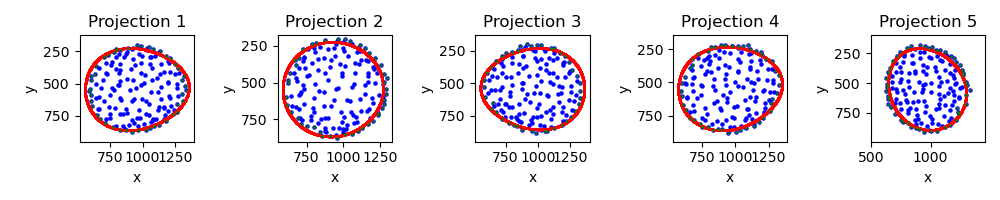

  40 Loss: 10665.20263671875 Volume: 4.249396 SSE: 1.3792447557358432 Chamfer: 0.016444090753793716
  41 Loss: 10484.42138671875 Volume: 4.249396 SSE: 1.3838257347481098 Chamfer: 0.016498330980539322
  42 Loss: 10353.59130859375 Volume: 4.249396 SSE: 1.388476131262241 Chamfer: 0.016553476452827454
  43 Loss: 10084.727783203125 Volume: 4.249396 SSE: 1.393205389227507 Chamfer: 0.016609665006399155
  44 Loss: 9924.302978515625 Volume: 4.249396 SSE: 1.3979849315071522 Chamfer: 0.01666657254099846
  45 Loss: 9777.667846679688 Volume: 4.249396 SSE: 1.4028151886487923 Chamfer: 0.016724176704883575
  46 Loss: 9626.416015625 Volume: 4.249396 SSE: 1.4077753274404057 Chamfer: 0.01678331568837166
  47 Loss: 420143.3203125 Volume: 4.249396 SSE: 1.4127701256914933 Chamfer: 0.016842950135469437
  48 Loss: 429500.703125 Volume: 4.249396 SSE: 1.4537554355508349 Chamfer: 0.017361272126436234
  49 Loss: 370007.734375 Volume: 4.249396 SSE: 1.485437502884679 Chamfer: 0.017764661461114883


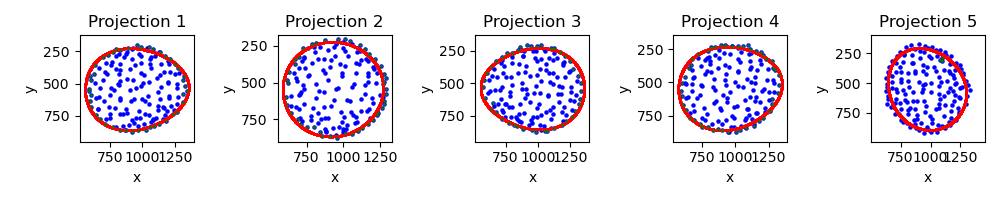

  50 Loss: 9184.600830078125 Volume: 4.249396 SSE: 1.513207810715695 Chamfer: 0.01811269111931324
  51 Loss: 9019.049682617188 Volume: 4.249396 SSE: 1.5176499691828804 Chamfer: 0.01816585473716259
  52 Loss: 8939.080200195312 Volume: 4.249396 SSE: 1.5221091095752624 Chamfer: 0.01821926236152649
  53 Loss: 8821.9189453125 Volume: 4.249396 SSE: 1.5265337101934635 Chamfer: 0.01827227883040905
  54 Loss: 9125.579833984375 Volume: 4.249396 SSE: 1.5309817133729235 Chamfer: 0.01832544058561325
  55 Loss: 9050.7470703125 Volume: 4.249396 SSE: 1.5355711916595511 Chamfer: 0.01838027313351631
  56 Loss: 8902.8125 Volume: 4.249396 SSE: 1.540182336432079 Chamfer: 0.01843537576496601
  57 Loss: 8756.652221679688 Volume: 4.249396 SSE: 1.5447980125569531 Chamfer: 0.01849057711660862
  58 Loss: 8656.461791992188 Volume: 4.249396 SSE: 1.5493694036765737 Chamfer: 0.018545296043157578
  59 Loss: 369342.1875 Volume: 4.249396 SSE: 1.553922672882057 Chamfer: 0.018599744886159897


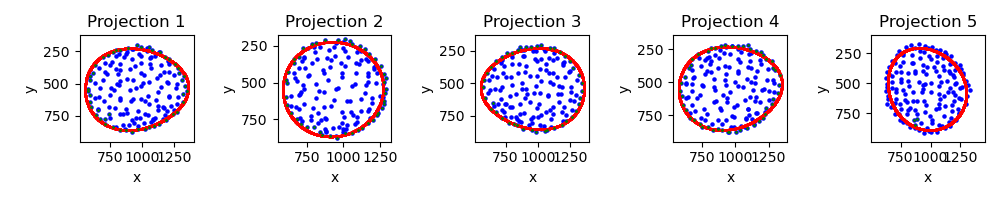

  60 Loss: 12330.294189453125 Volume: 4.249396 SSE: 1.5451874630367866 Chamfer: 0.01849391497671604
  61 Loss: 12140.491943359375 Volume: 4.249396 SSE: 1.5493555876781258 Chamfer: 0.018543509766459465
  62 Loss: 11992.252197265625 Volume: 4.249396 SSE: 1.5535656850440787 Chamfer: 0.01859366148710251
  63 Loss: 11884.08447265625 Volume: 4.249396 SSE: 1.5578221654898914 Chamfer: 0.018644385039806366
  64 Loss: 428043.046875 Volume: 4.249396 SSE: 1.5621240570113053 Chamfer: 0.018695713952183723
  65 Loss: 339183.3984375 Volume: 4.249396 SSE: 1.5729976202978453 Chamfer: 0.018839582800865173
  66 Loss: 315858.125 Volume: 4.249396 SSE: 1.5934648440447143 Chamfer: 0.01909247785806656
  67 Loss: 9038.0224609375 Volume: 4.249396 SSE: 1.5808856776008442 Chamfer: 0.019031919538974762
  68 Loss: 8973.787231445312 Volume: 4.249396 SSE: 1.5843536425564344 Chamfer: 0.019074229523539543
  69 Loss: 422358.828125 Volume: 4.249396 SSE: 1.5878528510274375 Chamfer: 0.019116956740617752


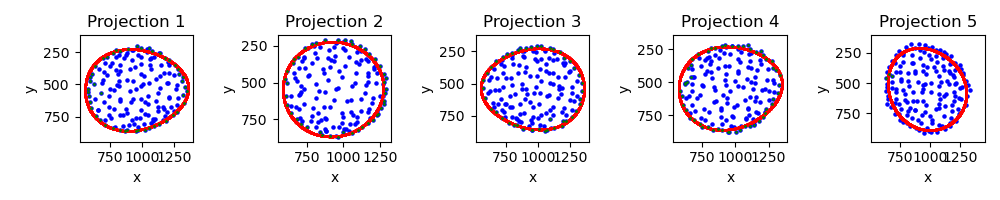

  70 Loss: 348372.1875 Volume: 4.249396 SSE: 1.6365006650660485 Chamfer: 0.019722895696759224
  71 Loss: 8816.349487304688 Volume: 4.249396 SSE: 1.6527184131507175 Chamfer: 0.019923366606235504
  72 Loss: 8721.248168945312 Volume: 4.249396 SSE: 1.6552359211455332 Chamfer: 0.019954713061451912
  73 Loss: 8683.565673828125 Volume: 4.249396 SSE: 1.6577819491857089 Chamfer: 0.01998639479279518
  74 Loss: 8537.830200195312 Volume: 4.249396 SSE: 1.6603954503878797 Chamfer: 0.020018912851810455
  75 Loss: 8449.739379882812 Volume: 4.249396 SSE: 1.6629951064548603 Chamfer: 0.020051270723342896
  76 Loss: 8366.755981445312 Volume: 4.249396 SSE: 1.6656376562250998 Chamfer: 0.02008415386080742
  77 Loss: 8275.993041992188 Volume: 4.249396 SSE: 1.6682670161345328 Chamfer: 0.02011689357459545
  78 Loss: 8157.66357421875 Volume: 4.249396 SSE: 1.670940344768521 Chamfer: 0.020150158554315567
  79 Loss: 8090.640869140625 Volume: 4.249396 SSE: 1.6736204507018098 Chamfer: 0.02018352597951889


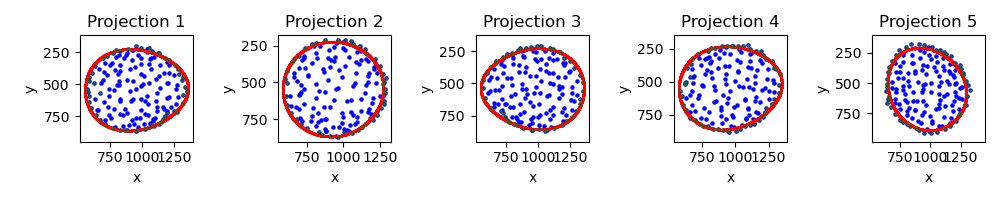

  80 Loss: 8031.168212890625 Volume: 4.249396 SSE: 1.6763594348057642 Chamfer: 0.020217621698975563
  81 Loss: 7319.8760986328125 Volume: 4.249396 SSE: 1.6790844363008095 Chamfer: 0.02025156468153
  82 Loss: 7287.2430419921875 Volume: 4.249396 SSE: 1.6816243316340402 Chamfer: 0.02028326317667961
  83 Loss: 7200.8123779296875 Volume: 4.249396 SSE: 1.6842003707731428 Chamfer: 0.020315423607826233
  84 Loss: 7153.3416748046875 Volume: 4.249396 SSE: 1.6867016238878796 Chamfer: 0.02034667506814003
  85 Loss: 7081.656494140625 Volume: 4.249396 SSE: 1.6892420434930102 Chamfer: 0.02037840522825718
  86 Loss: 7924.0435791015625 Volume: 4.249396 SSE: 1.691736591990011 Chamfer: 0.02040957845747471
  87 Loss: 471978.515625 Volume: 4.249396 SSE: 1.694232776564325 Chamfer: 0.020441927015781403
  88 Loss: 8551.344604492188 Volume: 4.249396 SSE: 1.704437318698158 Chamfer: 0.02057846263051033
  89 Loss: 7616.4349365234375 Volume: 4.249396 SSE: 1.7071945638431922 Chamfer: 0.020613927394151688


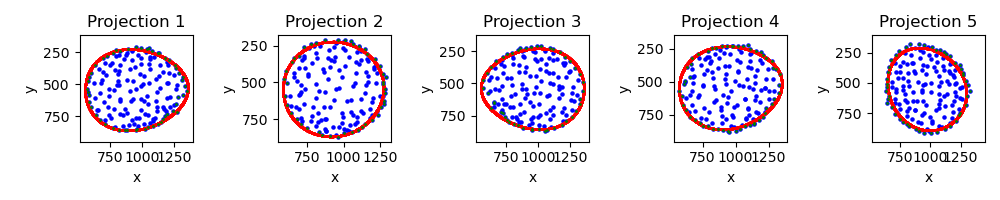

  90 Loss: 7590.736083984375 Volume: 4.249396 SSE: 1.709966998771369 Chamfer: 0.020648472011089325
  91 Loss: 8295.133666992188 Volume: 4.249396 SSE: 1.7128061732976476 Chamfer: 0.020683839917182922
  92 Loss: 7492.432861328125 Volume: 4.249396 SSE: 1.7155540514490377 Chamfer: 0.020719196647405624
  93 Loss: 7389.95361328125 Volume: 4.249396 SSE: 1.718497758386421 Chamfer: 0.020755838602781296
  94 Loss: 7327.069091796875 Volume: 4.249396 SSE: 1.7213442869019615 Chamfer: 0.02079130709171295
  95 Loss: 8098.4906005859375 Volume: 4.249396 SSE: 1.7241998988602627 Chamfer: 0.02082689106464386
  96 Loss: 7200.7281494140625 Volume: 4.249396 SSE: 1.7270514311077239 Chamfer: 0.02086353674530983
  97 Loss: 7025.1055908203125 Volume: 4.249396 SSE: 1.7299654630480326 Chamfer: 0.020899828523397446
  98 Loss: 400368.5546875 Volume: 4.249396 SSE: 1.7328157328230598 Chamfer: 0.020935392007231712
  99 Loss: 335204.6484375 Volume: 4.249396 SSE: 1.7998849210837242 Chamfer: 0.021752018481492996


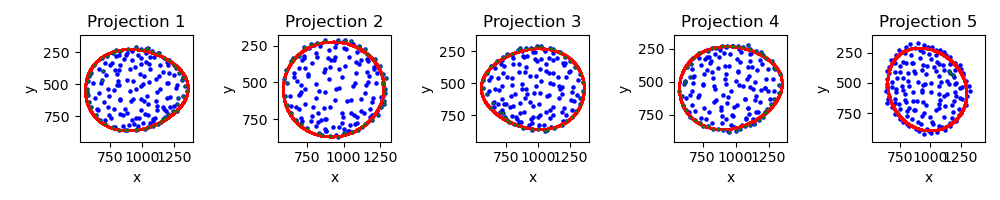

AttributeError: 'Canvas' object has no attribute 'key_press_event'

AttributeError: 'Canvas' object has no attribute 'key_release_event'

In [97]:
final_verts, history = outer_problem(sphere, parabola, projmats, batch_tgt_edgemap_info, n_iters=100, lr=5e-7,moment=0)

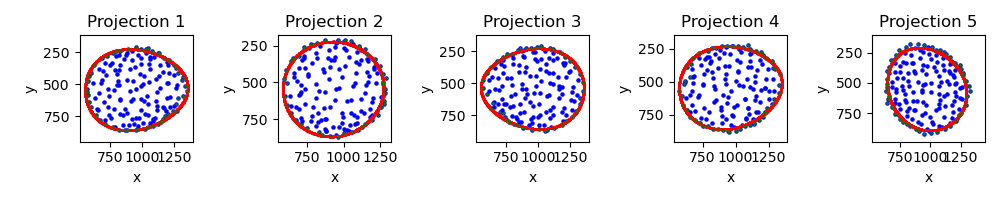

In [98]:
plot_projections(final_verts.detach().squeeze().double(), projmats, tgt_edgemap_info)

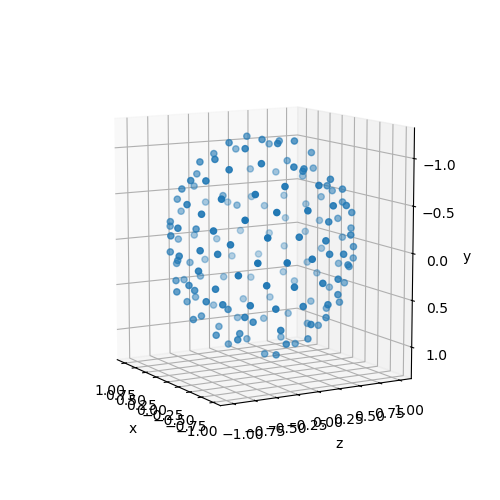

In [99]:
def plot_vertices(verts):
    x, y, z = verts.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_aspect("equal")
    ax.view_init(190, 30)
    plt.show()

plot_vertices(final_verts)

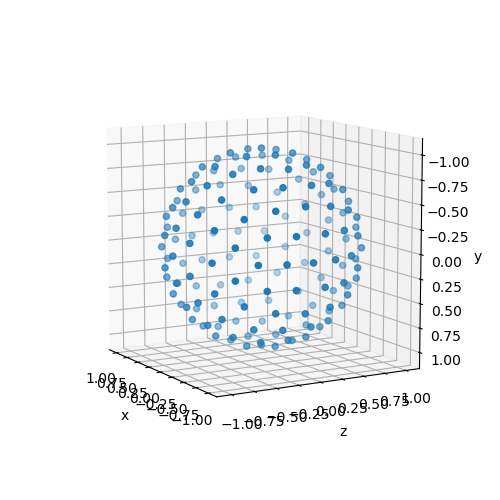

In [88]:
plot_vertices(sphere.verts_packed())

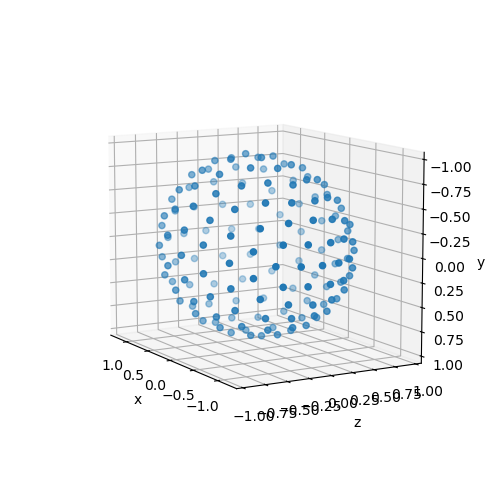

In [89]:
plot_vertices(balloon.verts_packed())